<a href="https://colab.research.google.com/github/narendra974/GAN/blob/main/vae_auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import tensorflow as tf
from keras.metrics import binary_crossentropy

In [2]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [3]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
nb_epoch = 50
epsilon_std = 1.0

In [4]:
def Sampling(args: tuple):
  z_mean, z_log_var  = args
  epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
  return z_mean + K.exp(z_log_var / 2) * epsilon

In [5]:
x = Input(shape=(original_dim), dtype='float32', name="input")
h = Dense(intermediate_dim, activation='relu', name='encoding')(x)
z_mean = Dense(latent_dim, name='mean')(h)
z_log_var = Dense(latent_dim, name='log-variance')(h)
z=Lambda(Sampling, output_shape=(latent_dim, ))([z_mean, z_log_var])
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 encoding (Dense)               (None, 256)          200960      ['input[0][0]']                  
                                                                                                  
 mean (Dense)                   (None, 2)            514         ['encoding[0][0]']               
                                                                                                  
 log-variance (Dense)           (None, 2)            514         ['encoding[0][0]']               
                                                                                            

In [6]:
input_decoder = Input(shape=(latent_dim), dtype='float32', name='decoder_input')
decoder_h = Dense(intermediate_dim, activation='relu', name='decoder_h')(input_decoder)
x_decoded = Dense(original_dim, activation='sigmoid', name='flat_decoded')(decoder_h)
decoder = Model(input_decoder, x_decoded, name='decoder')

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 decoder_h (Dense)           (None, 256)               768       
                                                                 
 flat_decoded (Dense)        (None, 784)               201488    
                                                                 
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


In [7]:
output_combined = decoder(encoder(x)[2])
vae = Model(x, output_combined)
vae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [8]:
def vae_loss(x:tf.Tensor, x_decoded_mean:tf.Tensor, z_log_var=z_log_var, z_mean=z_mean, original_dim=original_dim):
  xent_loss = original_dim * binary_crossentropy(x, x_decoded_mean)
  kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
  return xent_loss + kl_loss

In [9]:
vae.compile(optimizer='rmsprop', loss=vae_loss)

for layer in vae.layers:
    print(layer.name)

input
encoder
decoder


In [10]:
(x_train,y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape)
print(type(x_train))
vae.fit(x_train, x_train, shuffle=True, epochs=nb_epoch, batch_size=batch_size)

(60000, 784)
<class 'numpy.ndarray'>
Train on 60000 samples
Epoch 1/50
60000/60000 [==============================] - 17s 276us/sample - loss: 190.3301
Epoch 2/50
60000/60000 [==============================] - 11s 188us/sample - loss: 170.3007
Epoch 3/50
60000/60000 [==============================] - 9s 158us/sample - loss: 166.7054
Epoch 4/50
60000/60000 [==============================] - 9s 154us/sample - loss: 164.6196
Epoch 5/50
60000/60000 [==============================] - 9s 156us/sample - loss: 163.1717
Epoch 6/50
60000/60000 [==============================] - 9s 155us/sample - loss: 161.9819
Epoch 7/50
60000/60000 [==============================] - 9s 155us/sample - loss: 160.9147
Epoch 8/50
60000/60000 [==============================] - 9s 156us/sample - loss: 159.9145
Epoch 9/50
60000/60000 [==============================] - 10s 159us/sample - loss: 158.9608
Epoch 10/50
60000/60000 [==============================] - 9s 157us/sample - loss: 158.0791
Epoch 11/50
60000/60000 [=

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


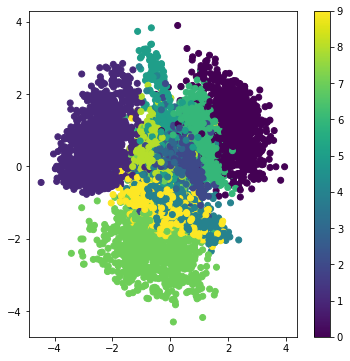

In [11]:
import matplotlib.pyplot as plt

x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()


In [ ]:
n = 15
digit_size = 28
figure = np.zeros((digit_size*n, digit_size*n ))

